In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

class Lumia():
    
    def __init__(self, dados={},heat_rate=[],pre_heat=False):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        self.data = dados
        self.pre_heat = pre_heat
        self.heat_rate = heat_rate
    #_______________________________________________________________________________________________________________

    def load_TL(self, arquivo,pre_heat=False, pre_heat_value=25, points_equal_temp=True,trimm_by='\t', lim_init = 4):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        with open(arquivo, 'r') as f:#Abre arquivo
            matrix = [[item for item in line.split(trimm_by)] for line in f.readlines()[lim_init:-1]]#Quebra linhas e colunas por tabulação
        matrixNumpy = np.array(matrix)                #matriz numpy
        curve={}                                     #variavel dicionario auxiliar
        for i in range(len(matrixNumpy.T)):       #É a iteração nas colunas pelo intervalo da matrix transposta do resultado
            lab=matrixNumpy[:,i]               #seleciona a coluna toda
            lista=[]                         #lista auxiliar
            for lin in lab:                   #iteração de valor em valor
                try:                         #evita bugs e erros por conversão falha
                    lista.append(int(lin))      #converte str para int
                except:
                    lista.append(np.nan)      #caso vazio e erro adiciona NAN
            if i == 0:                        #a primeira coluna é temperatura
                if pre_heat == False:          #Teste logico de preheat para soma de Temperatura inicial
                    curve.setdefault('Temperatura',lista) #Adciona o rótulo temperatura ao dicionario
                else:
                    lista = np.array(lista) + pre_heat_value #soma o preheat em um nd array
                    lista = list(lista)
                    curve.setdefault('Temperatura',lista) #adiciona a temperatura ao dicinario
            else:
                curve.setdefault('Curva {0}'.format(i),lista) #Adiciona as curvas ao dicionario
        data=pd.DataFrame(curve, index=curve['Temperatura']) #cria um pd.dataframe com os resultados
        self.data = data
        return data
    
        #_______________________________________________________________________________________________________________
    def add_data(self,arquivo):
        self.data = arquivo
        
         #______________________________________________________________________________________________________________
    def init_rise_prep(self,curva,lim_init=80,lim_fin=250,sig=0.07, npontos=13, pre_heat_val=25):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
    #variaveis importantes    
        k=0.00008617333262145                       #constante de bolzmann
                 #Diminuição do dataframe
        objeto = self.data[curva]
        curva1 = objeto[lim_init:lim_fin]            #Fatia o dataframe no intervalo de interesse
        limite = curva1.cumsum()                        #Determinação dos limites
        tol = limite[max(limite.index)]*sig            #Tolerância para seção do dataset
        atol = []                                     #lista vazia a ser preenchida com valores de intensidade TL
        index = []                                   #índice padrão
        temp = []                                  #temperatura em kelvin
    
        for it,num,cur in zip(limite,limite.index,curva1):
            if it < tol:
                atol.append(cur)
                temp.append(num+273)
                index.append(num)
        if pre_heat == True:
            temp = np.array(temp) + pre_heat_val
        else:
            pass 
        lim_temp = max(index)
        int_val = lim_temp - npontos #Seleciona 14 pontos
        diff = int_val-lim_init 
        Frame = pd.DataFrame()
        Frame['Temperatura (K)'] = temp
        Frame['TL'] = atol
        Frame['ln(TL)'] = np.log(atol)
        Frame['1/kt'] = 1/(k*Frame['Temperatura (K)'])
        Frame.index=index
        Frame= Frame[:][diff:]
        return Frame
    
        #_______________________________________________________________________________________________________________

    def init_rise_result(prepared_data):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        x = np.array(prepared_data['1/kt'])
        y = np.array(prepared_data['ln(TL)'])
        from scipy.stats import linregress
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        answer = {'Parametros present':{'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),'r^2':lin_reg.rvalue},
                 'Parametros Calc':{'Energia de Ativação':ea,'incerteza':lin_reg.stderr}}
    
        answerdb = {'Energia de Ativação':ea,'incerteza':lin_reg.stderr, 'r^2':lin_reg.rvalue}
        return answerdb
    
        #_______________________________________________________________________________________________________________

    def extract_ir(self):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        resposta = {'EA_IR(eV)':[],'error_ir':[],'r^2_ir':[],'objeto':[]}#conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        objeto = self.data
        for coluna in colunas:
            
            dados = self.init_rise_prep(curva=coluna)                #função de preparação
            answer = Lumia.init_rise_result(dados)                    #função de regressão
            resposta['EA_IR(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_ir'] += [answer['incerteza']]       #adição da resposta
            resposta['r^2_ir'] += [answer['r^2']]               #adição da resposta
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________
    def area_met_prep(self,curva,heat_rate, kin_order, lim_init=80,lim_fin=150,deltaT=1):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        objeto = self.data[curva]
        pre_heat= self.pre_heat
        if heat_rate > 6:
            lim_init=135 
            lim_fin=240 
        elif heat_rate ==6:
            lim_init=120
            lim_fin=220
        elif heat_rate == 5:
            lim_init=120
            lim_fin=220
        elif (heat_rate < 5) & (heat_rate>2):
            lim_init= 130
            lim_fin=  210
        elif heat_rate == 2:
            lim_init= 100
            lim_fin=  200
        elif heat_rate == 1:
            lim_init= 95
            lim_fin=  185
        elif heat_rate == 0.9:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.8:
            lim_init=95
            lim_fin= 190
        elif heat_rate == 0.7:
            lim_init=90
            lim_fin=180
        elif (heat_rate < 0.7) & (heat_rate > 0.4):
            lim_init=90
            lim_fin=175
        elif (heat_rate == 0.4):
            lim_init=85
            lim_fin=170
        elif (heat_rate == 0.3):
            lim_init=85
            lim_fin=170
        
        elif (heat_rate == 0.2) | (heat_rate == 0.1):
            lim_init=80
            lim_fin=160
        k=0.00008617333262145
        y = np.array(objeto[lim_init:lim_fin])
        x = np.array(objeto[lim_init:lim_fin].index)
        temp = x+273     #converte a temperatura para kelvin
        preview = pd.DataFrame()
        if pre_heat == True:
            temp+=25
        else:
            pass
        preview['Temperatura (K)'] = temp
        preview['TL'] = y
        preview.set_index(x, inplace=True)
        area=[]
        for i in range(len(y)):
            area.append((max(y[i:len(y)].cumsum()))*(deltaT/heat_rate))
        np.array(area)
        preview['area'] = area
        preview['1/kt'] =  1/(k*preview['Temperatura (K)'])
        preview['ln(TL/area)'] = np.log(preview.TL/preview.area)
        preview['hr'] = [heat_rate]*len(area)
        for ko in kin_order:
            pr = np.array(np.log(preview.TL/(preview.area)**ko))
            preview = dict(preview)
            preview.setdefault('b= {0}'.format(ko), pr)
            preview = pd.DataFrame(preview)
            self.area_result = preview
        return preview
       #_______________________________________________________________________________________________________________

 
        #_______________________________________________________________________________________________________________
    def area_result(prepared_data, heat_rate):
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import math
        from scipy.stats import linregress
    
        x = np.array(prepared_data['1/kt'])
        atr_list = list(prepared_data.columns)
        atr_list = atr_list[4:]
        r_squared = {}
    
        for atributo in atr_list:
            y=np.array(prepared_data[atributo])
            lin_reg = linregress(x,y)
            r_squared.setdefault(atributo,-1*lin_reg.rvalue)
        best = max(r_squared)
        y=np.array(prepared_data[best])
        lin_reg = linregress(x,y)
        ea = -1*lin_reg.slope
        escape_factor = heat_rate*math.exp(lin_reg.intercept)
        escape_error = lin_reg.intercept_stderr * escape_factor
        percentual_error = escape_error/escape_factor
        if best == 'ln(TL/area)':
            best = 'b = 1'
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                      'r^2':lin_reg.rvalue,
                      'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                      'Erro percentual':'{0} %'.format(percentual_error*100)}
        answer_db = {'Energia de Ativação':ea,
                 'Incerteza EA':lin_reg.stderr,
                 'r^2':lin_reg.rvalue,
                 'Fator de Escape':escape_factor, 
                 'Incerteza Escape_factor':escape_error,
                 'Percentual Error':percentual_error,
                 'Best_kin_order':best}                       
        return answer_present, answer_db
    
        #_______________________________________________________________________________________________________________


    def extract_area(self,heat_rate,test_kin_order):#informar uma lista com todas as taxas de aquecimento do DB
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        pre_heat = self.pre_heat
        resposta = {'EA_AREA(eV)':[],'error_AREA':[],'r^2_AREA':[],'freq_factor_AREA':[],
                    'ff_err_AREA':[],'ff_percerr_AREA':[],'AREA_kin_order':[],'objeto':[], 
                    'Taxa de aquecimento':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna, hr in zip(colunas, heat_rate):
            dados = self.area_met_prep(coluna,hr, test_kin_order)                #função de preparação
            answer_pres, answer = Lumia.area_result(dados,hr)                    #função de regressão
            resposta['EA_AREA(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_AREA'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_AREA'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_AREA'] += [answer['Fator de Escape']]
            resposta['ff_err_AREA'] += [answer['Incerteza Escape_factor']]
            resposta['ff_percerr_AREA'] += [answer['Percentual Error']]
            resposta['AREA_kin_order'] += [answer['Best_kin_order']]
            resposta['Taxa de aquecimento'] += [hr]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
    #_______________________________________________________________________________________________________________

    def peak_shape_met(curva,DeltaT=1,error=0.5, ph_val=25, pre_heat=False):
    #Encontrar a posição do pico
        peak = curva.max()

    #Encontrar o índice (Temperatura) do pico:

        j=0
        for i in curva:
            if i == peak:
                tmax = j*DeltaT
                break
            else:
                j+=1

    #Meia Altura
        half_peak = peak/2
    #Divisão do Dataset em dois
        t1_cand = np.array(curva[:tmax]) #Para T1
        t2_cand = np.array(curva[tmax:]) #Para T2

    #################################################################################################################

    #Testes lógicos para encontrar os índex respectivos
    # Fração inferior ao pico
        j=0
        for cand1 in t1_cand:
            if cand1 < half_peak:
                j0=j
                j+=1
            else:
                j2 = j0+1
                j+= 1
                continue
    # O j não reseta entre as iterações de t1_cand para t2_cand

    # Fração superior ao pico
        for cand2 in t2_cand:
            if cand2 > half_peak:
                j1=j
                j+=1
            else:
                j3 = j1+1
                break

    #Obtenção de T1 e transformação de ponto para temperatura
        if (half_peak - curva[j0]) < (curva[j2] - half_peak):
            t1 = j0 * DeltaT
        else:
            t1 = j2 * DeltaT
    #Obtenção de T2  
        if (curva[j1] - half_peak) < (half_peak - curva[j3]):
            t2 = j1 * DeltaT
        else:
            t2 = j3 * DeltaT
    ########################################################################################################################    

    # para kelvin
        t1 += 273
        t2 += 273
        tmax += 273
        k=0.00008617333262145
        
        if pre_heat == True:
            t1 += ph_val
            t2 += ph_val
            tmax += ph_val
        else:
            pass
    # Calculo dos parâmetros de forma
        delta = t2 - tmax
        omega = t2 - t1
        tau = tmax - t1
        shape_factor_mi = delta/omega
        shape_factor_gama = delta/tau

    #Energia de ativação

    #Omega de Chen
        omega_chen = (2.25+10.2*(shape_factor_mi - 0.42))*((k*tmax**2)/omega) - 1*(2*k*tmax)
    #Tau de Chen
        tau_chen = (1.510+3.0*(shape_factor_mi - 0.42))*((k*tmax**2)/tau) - (1.58+4.2*(shape_factor_mi - 0.42))*(2*k*tmax)
    #delta de Chen
        delta_chen = (0.976+7.3*(shape_factor_mi - 0.42))*((k*tmax**2)/delta)
    #kinetic order
        if shape_factor_mi < 0.44:
            kin_order = 'Primeira Ordem'
        elif shape_factor_mi < 0.50:
            kin_order = 'Ordem Geral'
        else:
            kin_order = 'Segunda Ordem'
    #Incertezas
    #delta
        delta_error = (2*(error/tmax) + (error/delta))*delta_chen
        mi_error = ((error/delta) + (error/omega))*shape_factor_mi
    #resposta
        answer = {'Parâmetros de forma':{'delta':'{0} K'.format(delta),'omega':'{0} K'.format(omega),'tau':'{0} K'.format(tau),
                                         'mi':'{0} ± {1}'.format(shape_factor_mi, mi_error)},
                  'Energia de Ativação':{'Delta de Chen':'{0} ± {1} eV'.format(delta_chen,delta_error),
                                         'Tau de Chen':'{0} eV'.format(tau_chen),
                                         'Omega de Chen':'{0} eV'.format(omega_chen)},
                  'Ordem Cinética':kin_order, 'Outras informações':{'TMax':'{0} K'.format(tmax),'T1':'{0} K'.format(t1),
                                                                'T2':'{0} K'.format(t2), 'IM':peak}}
        answerdb = {'Delta de Chen':delta_chen,
                    'deta_error':delta_error,
                    'Tau de Chen':tau_chen,
                    'Omega de Chen':omega_chen,
                    'Ordem Cinética':kin_order,
                    'Tmax':tmax,
                    'T1':t1,
                    'T2':t2,
                    'IM':peak,
                    'Mi':shape_factor_mi,
                    'mi_error':mi_error,
                    'delta':delta,
                    'Tau':tau,
                    'Omega':omega}
        return answer, answerdb
    
    #_______________________________________________________________________________________________________________
    def extract_pshape(self):
        pre_heat = self.pre_heat
        resposta = {'tau_chen(eV)':[],'omega_chen(eV)':[],'delta_chen(eV)':[],'delta_error':[],
                    'ordem_cinetica':[],'tmax':[],'t1':[],'t2':[],'IM':[],'Shape_factor':[],
                    'Sf_error':[],'objeto':[]} #conjunto resposta
        colunas = list(self.data.columns)
        colunas = colunas[1:]
        for coluna in colunas:              
            answer_pres, answer = Lumia.peak_shape_met(self.data[coluna],pre_heat=pre_heat)                    #função de regressão
            resposta['tau_chen(eV)'] += [answer['Tau de Chen']]#adição da resposta
            resposta['omega_chen(eV)'] += [answer['Omega de Chen']]       #adição da resposta
            resposta['delta_chen(eV)'] += [answer['Delta de Chen']]               #adição da resposta
            resposta['delta_error'] += [answer['deta_error']]       
            resposta['ordem_cinetica'] += [answer['Ordem Cinética']]          
            resposta['tmax'] += [answer['Tmax']]          
            resposta['t1'] += [answer['T1']]          
            resposta['t2'] += [answer['T2']]
            resposta['IM'] += [answer['IM']]
            resposta['Shape_factor'] += [answer['Mi']]
            resposta['Sf_error'] += [answer['mi_error']]
            resposta['objeto'] += [coluna]                      #adição da resposta
        return pd.DataFrame(resposta,index=resposta['objeto'])
    
     #_______________________________________________________________________________________________________________
    
    def multi_heating_rate_ti(curva1,curva2,heating_rate, DeltaT=1):
        pre_heat = self.pre_heat
    #Encontrar a posição do pico
        if pre_heat == True:
            pre_heat_temp=25
        else:
            pre_heat_temp=0
        k=0.00008617333262145
        curvas = [curva1,curva2] #transforma em um objeto tipo lista iteravel
        ind=0 # quando ind=0, sub index 1, quando ind=1 sub index 2
#Encontrar IM & TM de cada uma das curvas:
        for curva, hr in zip(curvas, heating_rate):
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT + pre_heat_temp
                    break
                else:
                    j+=1
            if ind == 0:
                tm1c = tmax
                Im1s = peak
                hr_1 = hr
                Im1 = peak/hr_1
                Tm1 = tm1c+ 273
             
            else:
                tm2c = tmax
                hr_2= hr
                Im2 = peak/hr_2
                Tm2 = tm2c + 273
            ind+=1
    #Calculo da Energia de ativação
        EA_beta = k * ((Tm1*Tm2)/(Tm1-Tm2))*np.log((hr_1/hr_2)*(Tm1/Tm2)**2)
        EA_Im = ((k*Tm1*Tm2)/(Tm1-Tm2))*np.log((Im1/Im2))
        return(EA_beta,EA_Im,Tm1,Tm2)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_prep(dataset,curvas,heating_rate, DeltaT=1,ph_val=25, pre_heat=False): 
        Df_new = {'Temperatura (C)':[], 'Temperatura (K)':[],'y':[],'x':[],'Heat_rate':[]}
        k=0.00008617333262145
        for curv, hr in zip(curvas, heating_rate):
            curva = dataset[curv]
            peak = curva.max()
            j=0
            for i in curva:
                if i == peak:
                    tmax = j*DeltaT
                    break
                else:
                    j+=1
            if pre_heat==True:
                tm1c = tmax+ph_val
            else:
                tm1c = tmax
            Tm = tm1c+ 273
            
            Df_new['Temperatura (C)'] += [tm1c]
            Df_new['Temperatura (K)'] += [Tm]
            Df_new['y'] += [np.log((Tm**2)/hr)]
            Df_new['x'] += [1/(k*Tm)]
            Df_new['Heat_rate'] += [hr]
        return pd.DataFrame(Df_new)

    #_______________________________________________________________________________________________________________
    def multi_heating_rate_reg(dados_preparados):#recebe a saída de multi_heating_rate_prep()
        from scipy.stats import linregress
        import math
        k=0.00008617333262145
        x = dados_preparados['x']
        y = dados_preparados['y']
    #Regressão Linear

        lin_reg = linregress(x,y) #Regressão
    
    #Calculo de parâmetros cinéticos

        ea = lin_reg.slope
        intercept = lin_reg.intercept
        escape_factor = ea*math.exp(-intercept/k)
        escape_per_error = (lin_reg.stderr/ea) + lin_reg.intercept_stderr
        escape_error = escape_per_error * escape_factor
    
    #Resposta   
        answer_present = {'Energia de Ativação':'{0}  ± {1} eV'.format(ea, lin_reg.stderr),
                            'r^2':lin_reg.rvalue,
                          'Fator de Escape':'{0} ± {1} eV'.format(escape_factor,escape_error),
                          'Erro percentual':'{0} %'.format(escape_per_error*100)}
        answer_db = {'Energia de Ativação':ea,
                     'Incerteza EA':lin_reg.stderr,
                     'r^2':lin_reg.rvalue,
                     'Fator de Escape':escape_factor, 
                     'Incerteza Escape_factor':escape_error,
                     'Percentual Error':escape_per_error} 
        return answer_present, answer_db
    #_______________________________________________________________________________________________________________

#Entra com o conjunto de dados e uma lista com a lista de nomes das curvas de cada amostra
    def extract_mhr(self,samples,heat_rate):#informar uma lista com todas as taxas de aquecimento do DB
        resposta = {'EA_mhr(eV)':[],'error_mhr':[],'r^2_mp':[],'freq_factor_mp':[],
                    'ff_percerr_mp':[],'Amostra':[] 
                    } #conjunto resposta
        amostra = 1
        pre_heat = self.pre_heat
        for sample in samples:
        
            dados = Lumia.multi_heating_rate_prep(self.data,sample,heat_rate,pre_heat=pre_heat)               #função de preparação
            answer_pres, answer = Lumia.multi_heating_rate_reg(dados)                    #função de regressão
            resposta['EA_mhr(eV)'] += [answer['Energia de Ativação']]#adição da resposta
            resposta['error_mhr'] += [answer['Incerteza EA']]       #adição da resposta
            resposta['r^2_mp'] += [answer['r^2']]               #adição da resposta
            resposta['freq_factor_mp'] += [answer['Fator de Escape']]
            resposta['ff_percerr_mp'] += [answer['Percentual Error']]
            resposta['Amostra'] += ['Amosta {0}'.format(amostra)]                      #adição da resposta
            amostra+=1
        return pd.DataFrame(resposta, index=resposta['Amostra'])

In [37]:
arquivo = Lumia(pre_heat=True)

In [38]:
arquivo.load_TL(r'C:\Users\André Tavares\Desktop\MESTRADO - CDTN\Resultados finais\Dados dose.txt', lim_init=2)
arquivo.data = arquivo.data[:][:350]
arquivo.data.pop('Curva 1')
time = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

In [39]:
time = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ir = arquivo.extract_ir()
ir['Tempo de irradiação'] = time
ir

,EA_IR(eV),error_ir,r^2_ir,objeto,Tempo de irradiação
Curva 2,1.432298,0.005969,-0.999896,Curva 2,1
Curva 3,1.457825,0.004625,-0.999940,Curva 3,2
Curva 4,1.443849,0.005265,-0.999920,Curva 4,3
Curva 5,1.437324,0.004299,-0.999946,Curva 5,4
Curva 6,1.436257,0.004830,-0.999932,Curva 6,5
Curva 7,1.427766,0.004562,-0.999939,Curva 7,6
Curva 8,1.430694,0.003249,-0.999969,Curva 8,7
Curva 9,1.430753,0.004005,-0.999953,Curva 9,8
Curva 10,1.418381,0.004236,-0.999946,Curva 10,9
Curva 11,1.422377,0.003442,-0.999965,Curva 11,10


In [24]:
heat_rate = [5]*15
area = arquivo.extract_area(heat_rate,[1.1,1.2,1.3])
area['Tempo de irradiação'] = time

In [25]:
area

,EA_AREA(eV),error_AREA,r^2_AREA,freq_factor_AREA,ff_err_AREA,ff_percerr_AREA,AREA_kin_order,objeto,Taxa de aquecimento,Tempo de irradiação
Curva 2,1.388232,0.008247,-0.998275,4.974502e+14,1.024203e+14,0.205891,b = 1,Curva 2,5,1
Curva 3,1.384367,0.007858,-0.998425,4.620779e+14,9.065358e+13,0.196187,b = 1,Curva 3,5,2
Curva 4,1.380793,0.007500,-0.998557,4.232643e+14,7.925300e+13,0.187242,b = 1,Curva 4,5,3
Curva 5,1.377018,0.007388,-0.998593,3.893618e+14,7.181309e+13,0.184438,b = 1,Curva 5,5,4
Curva 6,1.370926,0.007235,-0.998638,3.374158e+14,6.094592e+13,0.180626,b = 1,Curva 6,5,5
Curva 7,1.361099,0.007302,-0.998593,2.690309e+14,4.904442e+13,0.182300,b = 1,Curva 7,5,6
Curva 8,1.360771,0.007004,-0.998704,2.611275e+14,4.566243e+13,0.174866,b = 1,Curva 8,5,7
Curva 9,1.356833,0.006914,-0.998730,2.388332e+14,4.122412e+13,0.172606,b = 1,Curva 9,5,8
Curva 10,1.353340,0.006716,-0.998795,2.151319e+14,3.607073e+13,0.167668,b = 1,Curva 10,5,9
Curva 11,1.344469,0.006768,-0.998760,1.791926e+14,3.027923e+13,0.168976,b = 1,Curva 11,5,10


In [26]:
chen = arquivo.extract_pshape()
chen['Tempo de irradiação'] = time

In [27]:
chen

,tau_chen(eV),omega_chen(eV),delta_chen(eV),delta_error,ordem_cinetica,tmax,t1,t2,IM,Shape_factor,Sf_error,objeto,Tempo de irradiação
Curva 2,1.644287,1.489335,1.632430,0.057808,Ordem Geral,481,463,496,325985.0,0.454545,0.022039,Curva 2,1
Curva 3,1.512788,1.363131,1.502714,0.053215,Ordem Geral,481,462,496,603646.0,0.441176,0.021194,Curva 3,2
Curva 4,1.512788,1.363131,1.502714,0.053215,Ordem Geral,481,462,496,886253.0,0.441176,0.021194,Curva 4,3
Curva 5,1.512788,1.363131,1.502714,0.053215,Ordem Geral,481,462,496,1140773.0,0.441176,0.021194,Curva 5,4
Curva 6,1.512788,1.363131,1.502714,0.053215,Ordem Geral,481,462,496,1362043.0,0.441176,0.021194,Curva 6,5
Curva 7,1.396924,1.248577,1.380410,0.048884,Primeira Ordem,481,461,496,1584752.0,0.428571,0.020408,Curva 7,6
Curva 8,1.358410,1.192329,1.309720,0.049493,Primeira Ordem,482,462,496,1778157.0,0.411765,0.020761,Curva 8,7
Curva 9,1.396924,1.248577,1.380410,0.048884,Primeira Ordem,481,461,496,1989163.0,0.428571,0.020408,Curva 9,8
Curva 10,1.299920,1.149279,1.270166,0.044974,Primeira Ordem,482,461,497,2146731.0,0.416667,0.019676,Curva 10,9
Curva 11,1.396924,1.248577,1.380410,0.048884,Primeira Ordem,481,461,496,2317522.0,0.428571,0.020408,Curva 11,10


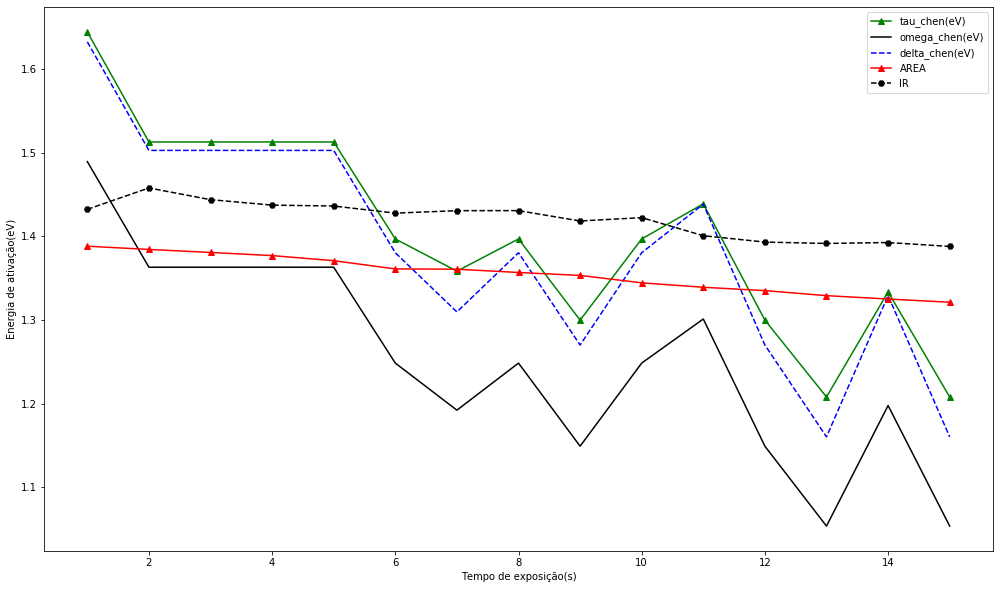

In [52]:
i = ['tau_chen(eV)','omega_chen(eV)','delta_chen(eV)']
cor = ['^g-','k-','b--']
Fig1=plt.Figure(figsize=(17,10)); ax = Fig1.add_subplot(1,1,1)
for isa,color in zip(i,cor):
    ax.plot(chen['Tempo de irradiação'], chen[isa], color, label= isa)
ax.plot(area['Tempo de irradiação'], area['EA_AREA(eV)'], '^r-', label= 'AREA')
ax.plot(ir['Tempo de irradiação'], ir['EA_IR(eV)'], 'Hk--', label= 'IR')
ax.legend(loc='best')
ax.set_ylabel('Energia de ativação(eV)')
ax.set_xlabel('Tempo de exposição(s)')

Fig1

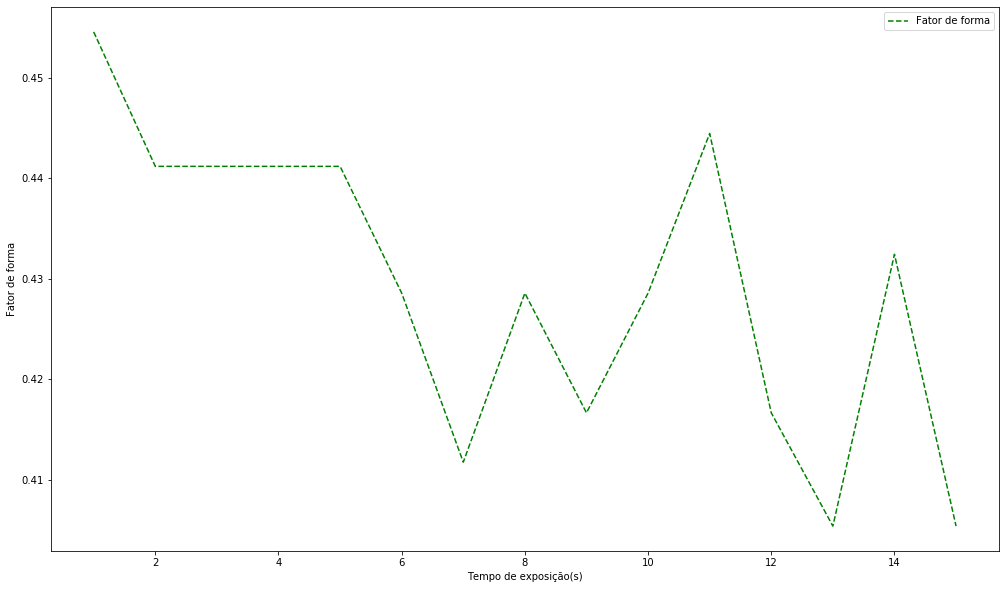

In [66]:
i = ['tau_chen(eV)','omega_chen(eV)','delta_chen(eV)']
cor = ['^g-','k-','b--']
Fig2=plt.Figure(figsize=(17,10)); ax = Fig2.add_subplot(1,1,1)
ax.plot(chen['Tempo de irradiação'], chen.Shape_factor, '--g', label= 'Fator de forma')
ax.legend(loc='best')
ax.set_ylabel('Fator de forma')
ax.set_xlabel('Tempo de exposição(s)')

Fig2

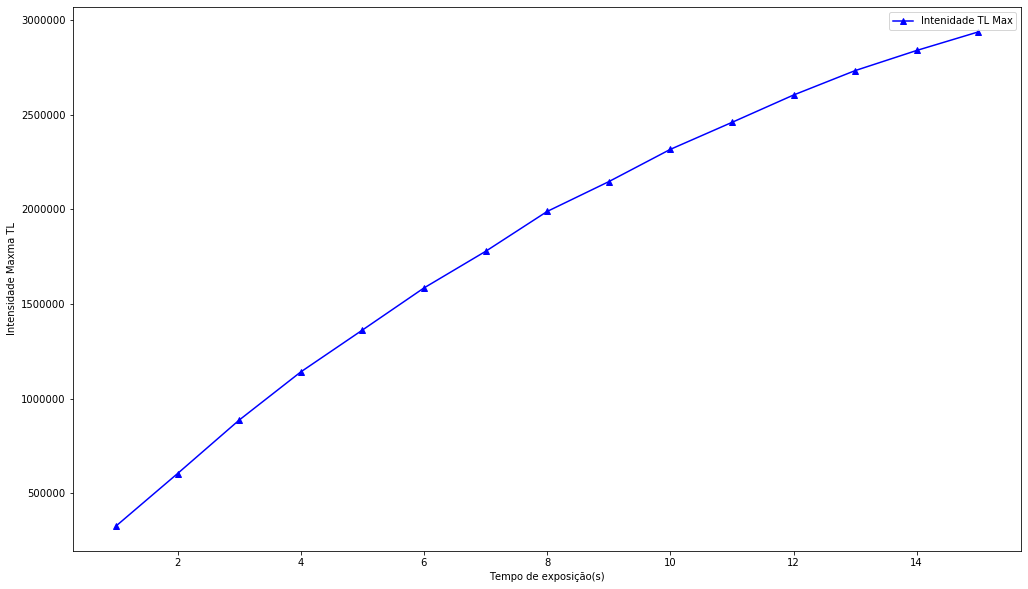

In [68]:
Fig2=plt.Figure(figsize=(17,10)); ax = Fig2.add_subplot(1,1,1)
ax.plot(chen['Tempo de irradiação'], chen.IM, '-^b', label= 'Intenidade TL Max')
ax.legend(loc='best')
ax.set_ylabel('Intensidade Maxma TL')
ax.set_xlabel('Tempo de exposição(s)')

Fig2

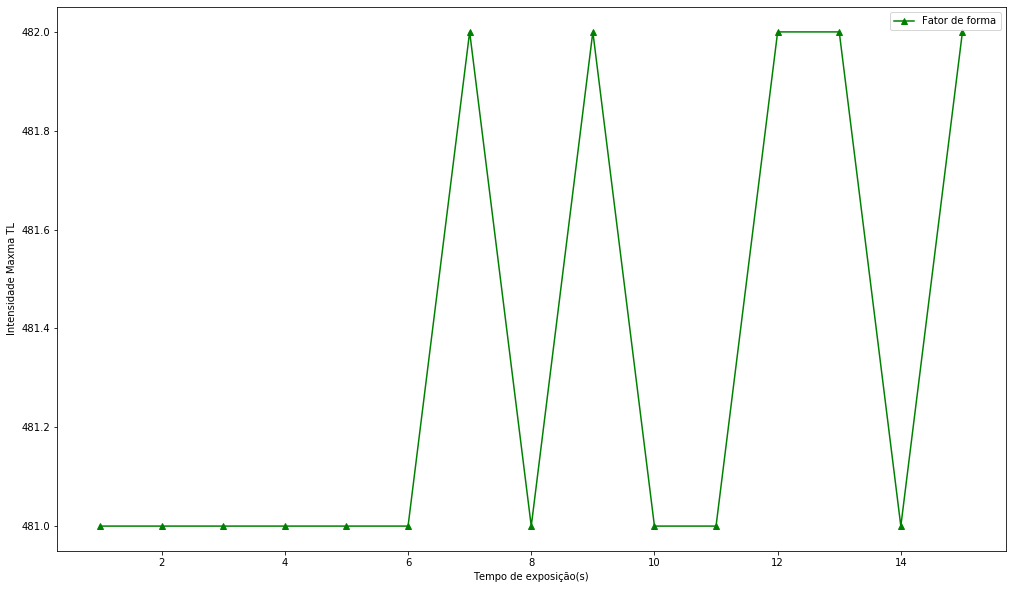

In [69]:
Fig4=plt.Figure(figsize=(17,10)); ax = Fig4.add_subplot(1,1,1)
ax.plot(chen['Tempo de irradiação'], chen.tmax, '-^g', label= 'Fator de forma')
ax.legend(loc='best')
ax.set_ylabel('Intensidade Maxma TL')
ax.set_xlabel('Tempo de exposição(s)')

Fig4

In [73]:
desvio = chen.tmax.std()
chen.tmax.mean()

481.3333333333333

In [75]:
import math
incerteza = desvio/math.sqrt(15) 
incerteza

0.12598815766974242

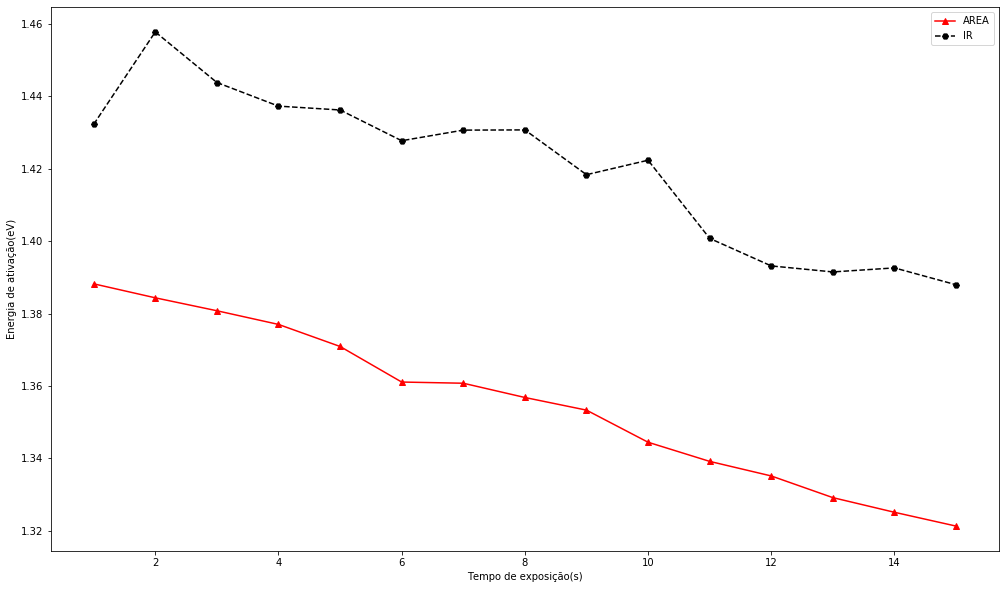

In [77]:
Fig4=plt.Figure(figsize=(17,10)); ax = Fig4.add_subplot(1,1,1)
ax.plot(area['Tempo de irradiação'], area['EA_AREA(eV)'], '^r-', label= 'AREA')
ax.plot(ir['Tempo de irradiação'], ir['EA_IR(eV)'], 'Hk--', label= 'IR')
ax.legend(loc='best')
ax.set_ylabel('Energia de ativação(eV)')
ax.set_xlabel('Tempo de exposição(s)')
Fig4

In [ ]:
F